In [29]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from lorenz_gan.submodels import SubModelGAN, AR1RandomUpdater
from lorenz_gan.gan import normalize_data, unnormalize_data
from lorenz_gan.analysis import hellinger, calc_pdf_hist
import pandas as pd
from os.path import join, exists
from os import environ
import pickle
import keras.backend as K
from keras.constraints import Constraint
from keras.initializers import VarianceScaling, RandomUniform, Initializer
from keras.layers import Layer, Input, Dense, Add
from keras.models import Model
from scipy.signal import cwt, ricker
from sklearn.preprocessing import StandardScaler
%matplotlib inline

In [10]:
gan_index = [700, 701, 702, 703, 801, 802, 803, 100, 101, 102, 103, 202, 203]
#gan_index = [702, 802, 102, 202]
#gan_index = [700, 701, 702, 703, 801, 802, 803]
gan_ds = {}
gan_ds_w = {}
for gi in gan_index:
    new_ds_fname = f"/glade/work/dgagne/exp_20_stoch/v1.5/gan_{gi}_climate/02000000/lorenz_forecast_02000000_00.nc"
    if exists(new_ds_fname):
        gan_ds[gi] = xr.open_dataset(new_ds_fname)
    white_ds_fname = f"/glade/work/dgagne/exp_20_stoch/v1.5/gan_{gi}_climate_white/02000000/lorenz_forecast_02000000_00.nc"
    if exists(white_ds_fname):
        gan_ds_w[gi] = xr.open_dataset(white_ds_fname)

In [8]:
gan_ds_w.keys()

dict_keys([702, 802])

In [3]:
poly = xr.open_dataset("/glade/work/dgagne/exp_20_stoch/poly_add_climate/02000000/lorenz_forecast_02000000_00.nc")
truth = xr.open_dataset("/glade/work/dgagne/exp_20_stoch/lorenz_output.nc")

In [4]:
start_index = 2000000
step_values = truth["step"].values
time_values = truth["time"].values

l_start = np.where(step_values == start_index)[0][0]
l_end = l_start + 2000000
truth["lorenz_x"][l_start:l_end, 0].shape

(2000000,)

In [5]:
truth_ts = pd.read_csv("/glade/work/dgagne/exp_20_stoch/lorenz_combined_output_test_x0.csv")


In [6]:
truth_train = pd.read_csv("/glade/work/dgagne/exp_20_stoch/lorenz_combined_output.csv")

In [7]:
gan_ds_w[700]["u"][:100, 1]

KeyError: 700

In [6]:
gan_index_color = {100: (0, 0.3052, 0.5057),
                   101: (0, 0.4470, 0.7410),
                   102: (0, 0.5364, 0.8892),
                   103: (0, 0.7558, 1),
                   202: (0.2796, 0.4044, 0.1128),
                   203: (0.5126, 0.7414, 0.2068),
                   700: (0.4250, 0.1625, 0.0490),
                   701: (0.6375, 0.2438, 0.0735),
                   702: (0.8500, 0.3250, 0.0980),
                   703: (1.0, 0.3930, 0.1186),
                   801: (0.5, 0.352, 0.050),
                   802: (0.7432, 0.5552, 0.100),
                   803: (1, 0.83280, 0.150),
                   900: "navy"}

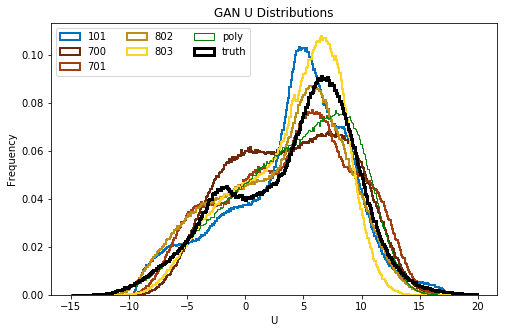

In [45]:
plt.figure(figsize=(8, 5))
bins = np.arange(-15, 20, 0.1)
for gi in [101, 700, 701, 802, 803]:
    _ = plt.hist(gan_ds[gi]["u"][:, 0], bins=bins, histtype="step", color=gan_index_color[gi], label=str(gi), lw=2, density=True)

#_ = plt.hist(gan_ds[102]["u"][:, 0], bins=bins, histtype="step", color='blue', label="102")
_ = plt.hist(poly["u"][:, 0], bins=bins, histtype="step", color='green', label="poly", density=True)

_ = plt.hist(truth_ts["Ux_t+1"][:2000000], bins=bins, histtype="step", color='black', label="truth", lw=3, density=True)
#plt.gca().set_yscale("log")
#_ = plt.hist(truth["lorenz_u"][l_start:l_end, 0], bins=bins, histtype="step", color='k', label="truth")
plt.legend(loc=2, ncol=3)
plt.xlabel("U")
plt.ylabel("Frequency")
plt.title("GAN U Distributions")
plt.savefig("gan_clim_700_800_series_u.png", dpi=200, bbox_inches="tight")

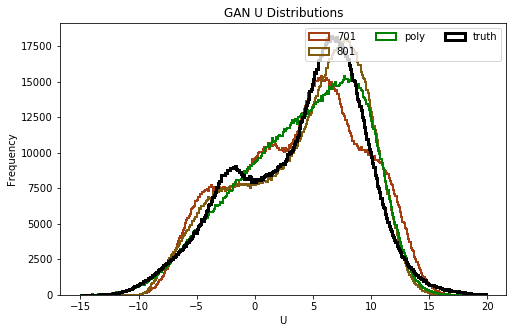

In [76]:
plt.figure(figsize=(8, 5))
bins = np.arange(-15, 20, 0.1)
for gi in [701, 801]:
    _ = plt.hist(gan_ds[gi]["u"][:, 0], bins=bins, histtype="step", color=gan_index_color[gi], label=str(gi), lw=2)

#_ = plt.hist(gan_ds[102]["u"][:, 0], bins=bins, histtype="step", color='blue', label="102")
_ = plt.hist(poly["u"][:, 0], bins=bins, histtype="step", color='green', label="poly", lw=2)

_ = plt.hist(truth_ts["Ux_t+1"][:2000000], bins=bins, histtype="step", color='black', label="truth", lw=3)
#plt.gca().set_yscale("log")
#_ = plt.hist(truth["lorenz_u"][l_start:l_end, 0], bins=bins, histtype="step", color='k', label="truth")
plt.legend(ncol=3)
plt.xlabel("U")
plt.ylabel("Frequency")
plt.title("GAN U Distributions")
plt.savefig("gan_clim_700_800_series_u.png", dpi=200, bbox_inches="tight")

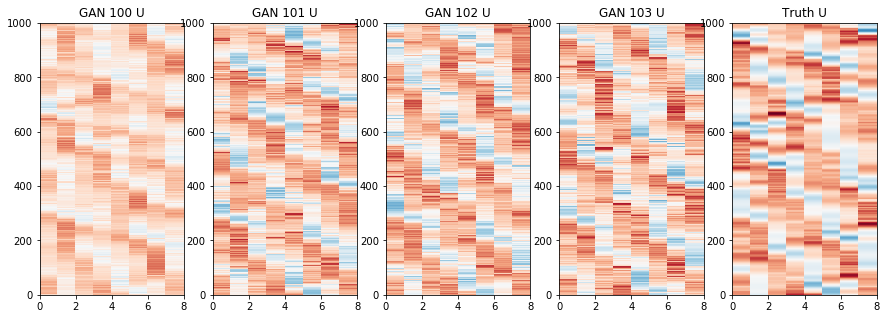

In [25]:
plt.figure(figsize=(15, 5))
for g, gi in enumerate([100, 101, 102, 103]):
    plt.subplot(1, 5, g + 1)
    plt.pcolormesh(gan_ds[gi]["u"][:1000], vmin=-20, vmax=20, cmap="RdBu_r")
    plt.title("GAN {0:d} U".format(gi))
plt.subplot(1, 5, 5)
plt.pcolormesh(truth_u[l_start:l_start + 1000], vmin=-20, vmax=20, cmap="RdBu_r")
plt.title("Truth U")
plt.savefig("hov_gan_100_u.png", dpi=200, bbox_inches="tight")

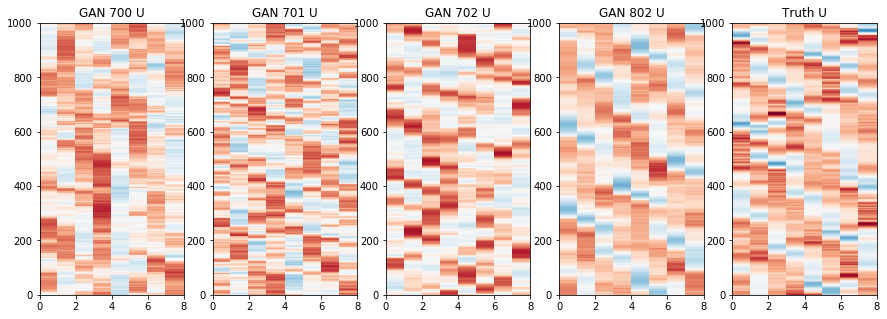

In [21]:
plt.figure(figsize=(15, 5))
for g, gi in enumerate([700, 701, 702, 802]):
    plt.subplot(1, 5, g + 1)
    plt.pcolormesh(gan_ds[gi]["u"][:1000], vmin=-20, vmax=20, cmap="RdBu_r")
    plt.title("GAN {0:d} U".format(gi))
plt.subplot(1, 5, 5)
plt.pcolormesh(truth_u[l_start:l_start + 1000], vmin=-20, vmax=20, cmap="RdBu_r")
plt.title("Truth U")
plt.savefig("hov_gan_700_u.png", dpi=200, bbox_inches="tight")

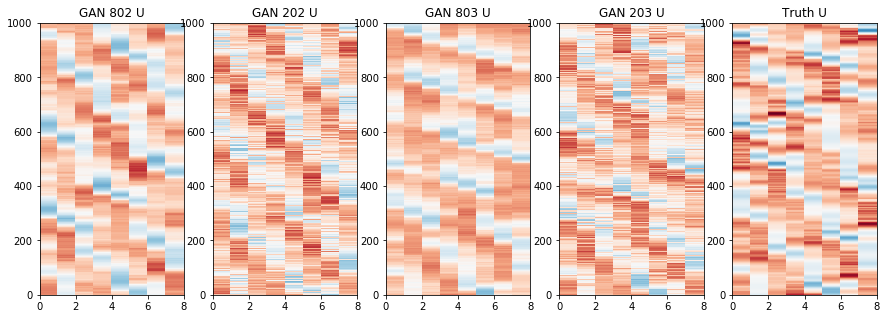

In [26]:
plt.figure(figsize=(15, 5))
for g, gi in enumerate([802, 202, 803, 203]):
    plt.subplot(1, 5, g + 1)
    plt.pcolormesh(gan_ds[gi]["u"][:1000], vmin=-20, vmax=20, cmap="RdBu_r")
    plt.title("GAN {0:d} U".format(gi))
plt.subplot(1, 5, 5)
plt.pcolormesh(truth_u[l_start:l_start + 1000], vmin=-20, vmax=20, cmap="RdBu_r")
plt.title("Truth U")
plt.savefig("hov_gan_800_u.png", dpi=200, bbox_inches="tight")

Text(0.5,1,'Truth X')

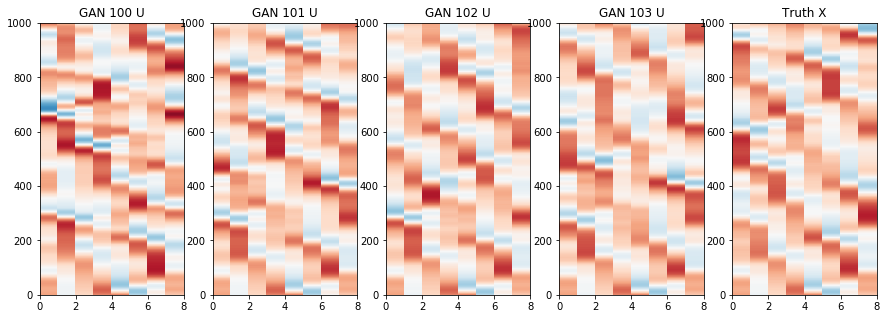

In [107]:
plt.figure(figsize=(15, 5))
for g, gi in enumerate([100, 101, 102, 103]):
    plt.subplot(1, 5, g + 1)
    plt.pcolormesh(gan_ds[gi]["x"][:1000], vmin=-20, vmax=20, cmap="RdBu_r")
    plt.title("GAN {0:d} U".format(gi))
plt.subplot(1, 5, 5)
plt.pcolormesh(X_out[l_start:l_start + 1000], vmin=-20, vmax=20, cmap="RdBu_r")
plt.title("Truth X")

Text(0.5,1,'Truth X')

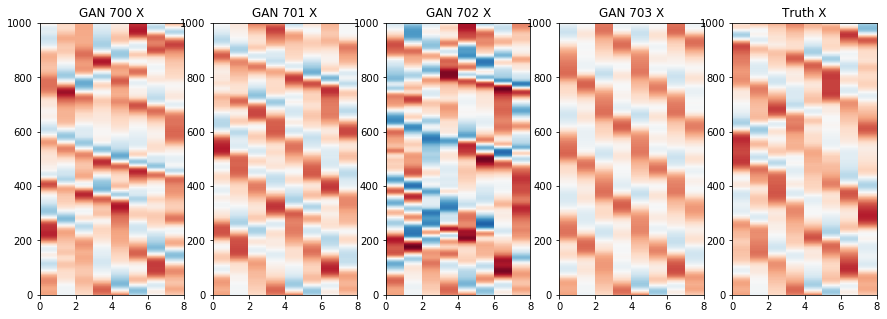

In [22]:
plt.figure(figsize=(15, 5))
for g, gi in enumerate([700, 701, 702, 703]):
    plt.subplot(1, 5, g + 1)
    plt.pcolormesh(gan_ds[gi]["x"][:1000], vmin=-20, vmax=20, cmap="RdBu_r")
    plt.title("GAN {0:d} X".format(gi))
plt.subplot(1, 5, 5)
plt.pcolormesh(X_out[l_start:l_start + 1000], vmin=-20, vmax=20, cmap="RdBu_r")
plt.title("Truth X")

In [15]:
truth_ts.iloc[l_start:l_end].shape

(2000000, 7)

In [13]:
gan_ds[gi]["u"][:, 1].values.shape

(2000000,)

In [22]:
np.logspace(0, 7, 7)

array([1.00000000e+00, 1.46779927e+01, 2.15443469e+02, 3.16227766e+03,
       4.64158883e+04, 6.81292069e+05, 1.00000000e+07])

In [75]:
def hellinger_joint(x, y, pdf_p, pdf_q):
    pdf_distances = (np.sqrt(pdf_p) - np.sqrt(pdf_q)) ** 2
    return np.mean(pdf_distances) / 2

In [76]:
x_bins = np.arange(-20, 21, 1)
truth_x_pdf = calc_pdf_hist(truth_ts.iloc[l_start:l_end]["X_t"].values, x_bins)
truth_u_pdf = calc_pdf_hist(truth_ts.iloc[l_start:l_end]["Ux_t+1"].values, x_bins)
truth_joint_pdf = np.histogram2d(gan_ds[gi]["x"][:, 0].values, gan_ds[gi]["u"][:, 0].values, 
                                (x_bins, x_bins), density=True)[0]
gan_configs = [700, 701, 702, 703, 801, 802, 803, 100, 101, 102, 103, 202, 203]
h_x_vals = pd.DataFrame(0, index=gan_configs, columns=["x", "u", "joint", "total"])
for g, gi in enumerate(gan_configs):
    print(gi)
    gan_x_pdf = calc_pdf_hist(gan_ds[gi]["x"][:, 0].values, x_bins)
    gan_u_pdf = calc_pdf_hist(gan_ds[gi]["u"][:, 0].values, x_bins)
    gan_joint_pdf = np.histogram2d(gan_ds[gi]["x"][:, 0].values, gan_ds[gi]["u"][:, 0].values, 
                                   (x_bins, x_bins), density=True)[0]
    h_x_vals.loc[gi, "x"] = hellinger(x_bins[:-1], truth_x_pdf, gan_x_pdf)
    h_x_vals.loc[gi, "u"] = hellinger(x_bins[:-1], truth_x_pdf, gan_u_pdf)
    h_x_vals.loc[gi, "joint"] = hellinger_joint(x_bins[:-1], x_bins[:-1], truth_joint_pdf, gan_joint_pdf)
    h_x_vals.loc[gi, "total"] = h_x_vals.loc[gi, "x"] + h_x_vals.loc[gi, "u"]
poly_x_pdf = calc_pdf_hist(poly["x"][:, 0].values, x_bins)
poly_u_pdf = calc_pdf_hist(poly["u"][:, 0].values, x_bins)
poly_joint_pdf = np.histogram2d(poly["x"][:, 0].values, poly["u"][:, 0].values, 
                                   (x_bins, x_bins), density=True)[0]
h_x_vals.loc["poly", "x"] = hellinger(x_bins[:-1], truth_x_pdf, poly_x_pdf)
h_x_vals.loc["poly", "u"] = hellinger(x_bins[:-1], truth_x_pdf, poly_u_pdf)
h_x_vals.loc["poly", "joint"] = hellinger_joint(x_bins[:-1], x_bins[:-1], truth_joint_pdf, poly_joint_pdf)

h_x_vals.loc["poly", "total"] = h_x_vals.loc["poly", "x"] + h_x_vals.loc["poly", "u"]

700
701
702
703
801
802
803
100
101
102
103
202
203


In [83]:
titles = ["XU-lrg-r", "XU-med-r", "XU-sml-r", "XU-tny-r", "X-med-r", "X-sml-r", "X-tny-r",
          "XU-lrg-w*", "XU-med-w*", "XU-sml-w*", "XU-tny-w*", 'X-sml-w*', "X-tny-w*", "Poly"]
h_x_vals["title"] = titles

In [85]:
h_x_vals.sort_values("scaled_total")

,x,u,joint,total,scaled_total,title
203,0.000366,0.014735,0.000239,0.015101,0.065957,X-tny-w*
701,0.004569,0.009089,0.000239,0.013658,0.076016,XU-med-r
202,0.000540,0.016318,0.000237,0.016858,0.079770,X-sml-w*
poly,0.000877,0.016534,0.000226,0.017410,0.085494,Poly
102,0.000327,0.021157,0.000245,0.021484,0.112818,XU-sml-w*
103,0.000843,0.021934,0.000234,0.022777,0.124890,XU-tny-w*
802,0.000649,0.023000,0.000257,0.023648,0.130352,X-sml-r
700,0.012913,0.005852,0.000260,0.018765,0.154752,XU-lrg-r
801,0.001254,0.025486,0.000248,0.026739,0.156116,X-med-r
101,0.000493,0.027196,0.000248,0.027689,0.159366,XU-med-w*


In [82]:
h_x_vals["scaled_total"] = (h_x_vals["x"] -h_x_vals["x"].min())/  (h_x_vals["x"].max() - h_x_vals["x"].min()) + \
    (h_x_vals["u"] -h_x_vals["u"].min())/  (h_x_vals["u"].max() - h_x_vals["u"].min())

700
701
702
703
801
802
803
100
101
102
103
202
203


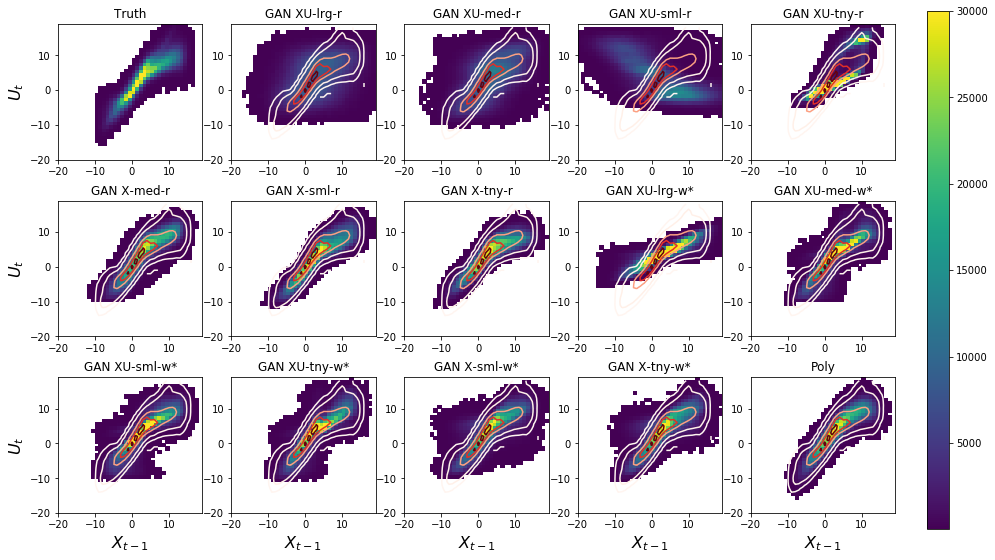

In [27]:
fig = plt.figure(figsize=(15, 9))
plt.subplots_adjust(hspace=0.3)
plt.subplot(3, 5, 1)
h2d_truth, h2d_x_bins, h2d_y_bins, stuff = plt.hist2d(truth_ts.iloc[l_start:l_end]["X_t"], truth_ts.iloc[l_start:l_end]["Ux_t+1"], 
                                                      bins=np.arange(-20, 21), cmin=1, vmin=1, vmax=30000, cmap="viridis")
plt.title("Truth")
plt.ylabel("$U_t$", fontsize=16)
titles = ["XU-lrg-r", "XU-med-r", "XU-sml-r", "XU-tny-r", "X-med-r", "X-sml-r", "X-tny-r",
          "XU-lrg-w*", "XU-med-w*", "XU-sml-w*", "XU-tny-w*", 'X-sml-w*', "X-tny-w*", "Poly"]
for g, gi in enumerate([700, 701, 702, 703, 801, 802, 803, 100, 101, 102, 103, 202, 203]):
    print(gi)
    plt.subplot(3, 5, g + 2)
    plt.hist2d(gan_ds[gi]["x"][:, 1].values, gan_ds[gi]["u"][:, 1].values, 
               bins=np.arange(-20, 21), cmin=1, vmin=1, vmax=30000, cmap="viridis")
    plt.contour(h2d_x_bins[:-1], h2d_y_bins[:-1], h2d_truth.T, [0, 1, 100, 1000, 10000, 20000, 30000], vmin=1, vmax=30000, cmap="Reds",)
    plt.title(f"GAN {titles[g]}")
    if g+2 > 10:
        plt.xlabel("$X_{t-1}$", fontsize=16)
    if (g + 1) % 5 == 0:
        plt.ylabel("$U_t$", fontsize=16)
plt.subplot(3, 5, 15)
cont = plt.hist2d(poly["x"][:, 0].values, poly["u"][:, 0].values, bins=np.arange(-20, 21), cmin=1, vmin=1, vmax=30000, cmap="viridis")[-1]
plt.contour(h2d_x_bins[:-1], h2d_y_bins[:-1], h2d_truth.T, [0, 1, 100, 1000, 10000, 20000, 30000], vmin=1, vmax=30000, cmap="Reds")
plt.title("Poly")
plt.xlabel("$X_{t-1}$", fontsize=16)
cb_ax = fig.add_axes([0.93, 0.1, 0.02, 0.8])
cbar = fig.colorbar(cont, cax=cb_ax)
plt.savefig("gan_clim_2d_hist.png", dpi=200, bbox_inches="tight")
plt.savefig("gan_clim_2d_hist.pdf", dpi=200, bbox_inches="tight")

203
701
202
poly
102
103
802
700
801
101
803
100
703
702


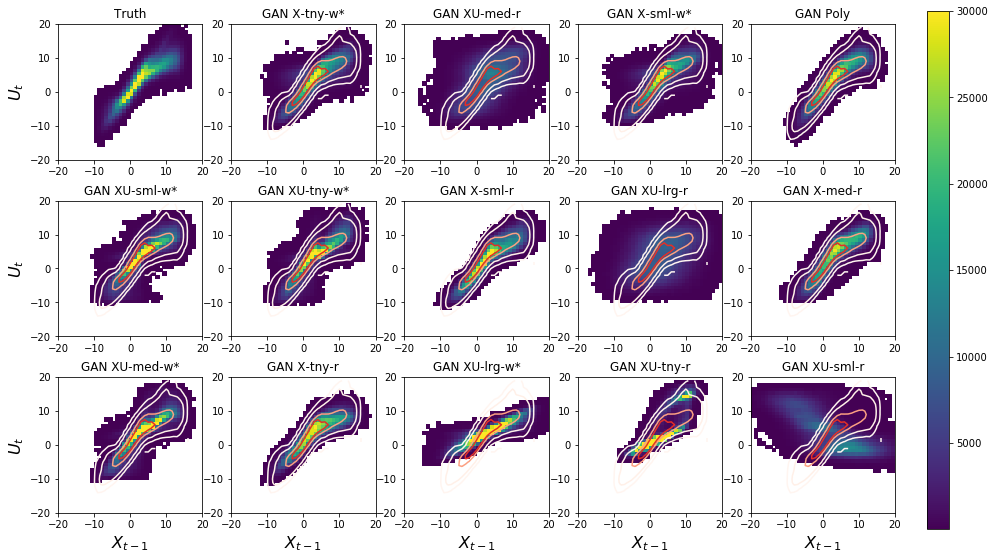

In [86]:
fig = plt.figure(figsize=(15, 9))
plt.subplots_adjust(hspace=0.3)
plt.subplot(3, 5, 1)
h2d_truth, h2d_x_bins, h2d_y_bins, stuff = plt.hist2d(truth_ts.iloc[l_start:l_end]["X_t"], truth_ts.iloc[l_start:l_end]["Ux_t+1"], 
                                                      bins=np.arange(-20, 21), cmin=1, vmin=1, vmax=30000, cmap="viridis")
plt.title("Truth")
plt.ylabel("$U_t$", fontsize=16)
titles = np.array(["XU-lrg-r", "XU-med-r", "XU-sml-r", "XU-tny-r", "X-med-r", "X-sml-r", "X-tny-r",
          "XU-lrg-w*", "XU-med-w*", "XU-sml-w*", "XU-tny-w*", 'X-sml-w*', "X-tny-w*"])
for g, gi in enumerate(h_x_vals.sort_values("scaled_total").index):
    print(gi)
    plt.subplot(3, 5, g + 2)
    if gi == "poly":
        cont = plt.hist2d(poly["x"][:, 0].values, poly["u"][:, 0].values, bins=np.arange(-20, 21), cmin=1, vmin=1, vmax=30000, cmap="viridis")[-1]
        plt.title("Poly")
    else:
        cont = plt.hist2d(gan_ds[gi]["x"][:, 1].values, gan_ds[gi]["u"][:, 1].values, 
               bins=np.arange(-20, 21), cmin=1, vmin=1, vmax=30000, cmap="viridis")[-1]
    plt.contour(h2d_x_bins[:-1], h2d_y_bins[:-1], h2d_truth.T, [0, 1, 100, 1000, 10000, 20000], vmin=1, vmax=30000, cmap="Reds",)
    title_name = h_x_vals.loc[gi, "title"]
    plt.title(f"GAN {title_name}")
    if g+2 > 10:
        plt.xlabel("$X_{t-1}$", fontsize=16)
    if (g + 1) % 5 == 0:
        plt.ylabel("$U_t$", fontsize=16)
cb_ax = fig.add_axes([0.93, 0.1, 0.02, 0.8])
cbar = fig.colorbar(cont, cax=cb_ax)
plt.savefig("gan_clim_2d_hist_ranked.png", dpi=200, bbox_inches="tight")
plt.savefig("gan_clim_2d_hist_ranked.pdf", dpi=200, bbox_inches="tight")

203
13916.0
701
24979.0
202
16080.0
poly
13109.0
102
32067.0
103
22890.0
802
15509.0
700
26333.0
801
13544.0
101
19703.0
803
13265.0
100
41626.0
703
87619.0
702
28419.0


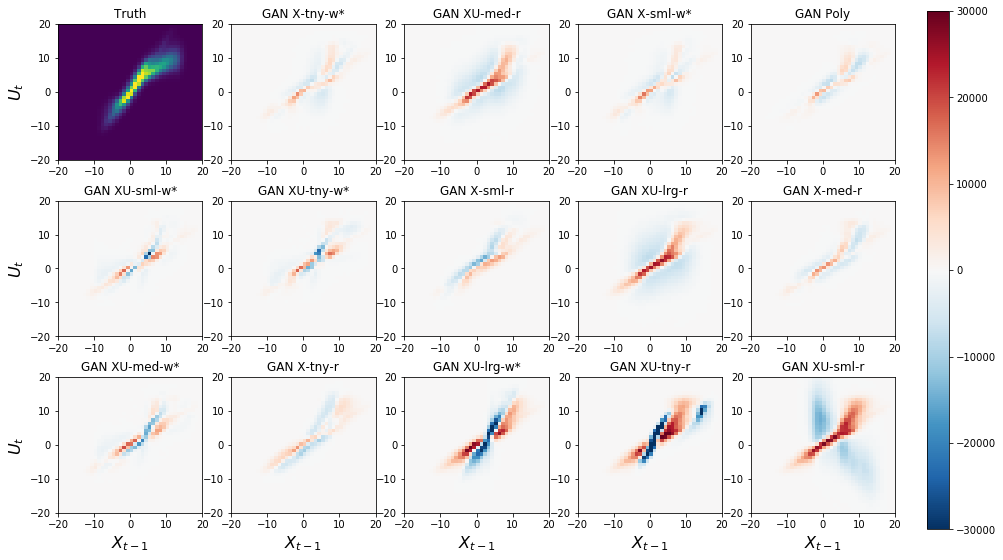

In [100]:
fig = plt.figure(figsize=(15, 9))
plt.subplots_adjust(hspace=0.3)
plt.subplot(3, 5, 1)
h2d_truth, h2d_x_bins, h2d_y_bins, stuff = plt.hist2d(truth_ts.iloc[l_start:l_end]["X_t"], truth_ts.iloc[l_start:l_end]["Ux_t+1"], 
                                                      bins=np.arange(-20, 21), cmin=0, vmin=1, vmax=30000, cmap="viridis")
plt.title("Truth")
plt.ylabel("$U_t$", fontsize=16)
titles = np.array(["XU-lrg-r", "XU-med-r", "XU-sml-r", "XU-tny-r", "X-med-r", "X-sml-r", "X-tny-r",
          "XU-lrg-w*", "XU-med-w*", "XU-sml-w*", "XU-tny-w*", 'X-sml-w*', "X-tny-w*"])
for g, gi in enumerate(h_x_vals.sort_values("scaled_total").index):
    print(gi)
    plt.subplot(3, 5, g + 2)
    if gi == "poly":
        poly_hist = np.histogram2d(poly["x"][:, 0].values, poly["u"][:, 0].values, 
                              bins=np.arange(-20, 21))[0]
        diff = h2d_truth - poly_hist
        v_max = np.nanmax(np.abs(diff))
        print(v_max)
        v_max=30000
        cont = plt.pcolormesh(h2d_x_bins, h2d_y_bins, diff, vmin=-v_max,vmax=v_max, cmap="RdBu_r")
        plt.title("Poly")
    else:
        gan_hist = np.histogram2d(gan_ds[gi]["x"][:, 0].values, gan_ds[gi]["u"][:, 0].values, 
                              bins=np.arange(-20, 21))[0]
        diff = h2d_truth - gan_hist
        v_max = np.nanmax(np.abs(diff))
        print(v_max)
        v_max=30000
        cont = plt.pcolormesh(h2d_x_bins, h2d_y_bins, diff, vmin=-v_max,vmax=v_max, cmap="RdBu_r")
    title_name = h_x_vals.loc[gi, "title"]
    plt.title(f"GAN {title_name}")
    if g+2 > 10:
        plt.xlabel("$X_{t-1}$", fontsize=16)
    if (g + 1) % 5 == 0:
        plt.ylabel("$U_t$", fontsize=16)
cb_ax = fig.add_axes([0.93, 0.1, 0.02, 0.8])
cbar = fig.colorbar(cont, cax=cb_ax)
plt.savefig("gan_clim_2d_diff.png", dpi=200, bbox_inches="tight")
plt.savefig("gan_clim_2d_diff.pdf", dpi=200, bbox_inches="tight")

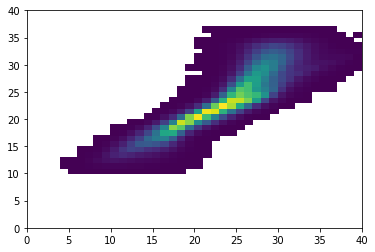

In [94]:
plt.pcolormesh(h2d_truth)

In [89]:
#gw_index = [700, 701, 702, 703, 801, 802, 803]
#gw_star_index = [100, 101, 102, 103, 202, 203]
gw_index = [702, 802]
gw_star_index = [102, 202]
#widths = np.arange(1, 17)
widths = np.arange(10, 400, 10)
wavelets = np.zeros((len(gan_index), widths.size, gan_ds[gan_index[0]]["x"].shape[0]))
wavelets_red = np.zeros((len(gw_index), widths.size, gan_ds[gan_index[0]]["x"].shape[0]))
wavelets_white = np.zeros((len(gw_index), widths.size, gan_ds[gan_index[0]]["x"].shape[0]))
wavelets_white_star = np.zeros((len(gw_star_index), widths.size, gan_ds[gan_index[0]]["x"].shape[0]))
for g, gi in enumerate(gw_index):
    print(gi)
    #wavelets[g] = cwt(gan_ds[gi]["x"][:, 0], ricker, 2 ** widths)
    wavelets_red[g] = cwt(gan_ds[gi]["x"][:, 0], ricker, widths)
    wavelets_white[g] = cwt(gan_ds_w[gi]["x"][:, 0], ricker, widths)
for g, gi in enumerate(gw_star_index):
    print(gi)
    wavelets_white_star[g] = cwt(gan_ds[gi]["x"][:, 0], ricker, widths)
wout_poly = cwt(poly["x"][:, 0], ricker, widths)
wout_truth = cwt(truth["lorenz_x"][l_start:l_end, 0], ricker, widths)

702
802
102
202


In [97]:
gan_index_color = {100: (0.2930,         0,    0.5078),
                   101: (0.4766,    0.2487,    0.6198),
                   102: (0.6602,    0.4974,   0.7318),
                   103: ( 0.8438,    0.7461,    0.8438),
                   202: (0.7773,    0.0820,    0.5195),
                   203: (0.8555,    0.4375,    0.5742),
                   700: (0,    0.3052,    0.5057),
                   701: (0,    0.4470,    0.7410),
                   702: (0,    0.5364,    0.8892),
                   703: (0,    0.7558,    1),
                   801: (0.2796,    0.4044,    0.1128),
                   802: (0.5126,    0.7414,    0.2068),
                   803: ( 0.7922,    0.9458,    0.3196)}
gan_index_red_colors = {700: ( 0.4250,    0.1625,    0.0490),
                        701: (0.6375,    0.2438,    0.0735),
                        702: (0.8500,    0.3250,    0.0980),
                        703: (1,         0.3930,    0.1186),
                        801: (1.0000,    0.5469,         0),
                        802: (1.0000,    0.6934,         0),
                        803: (1.0000,    0.8398,         0)
                       }

In [101]:
gan_index_color = {102: (0.3, 0.3, 0.3),
                   202: (0.75, 0.75, 0.75),
                   702: (0.85, 0.225, 0.0980),
                   802: (1.0, 0.5469, 0),
                  }
gan_index_red_colors = gan_index_color

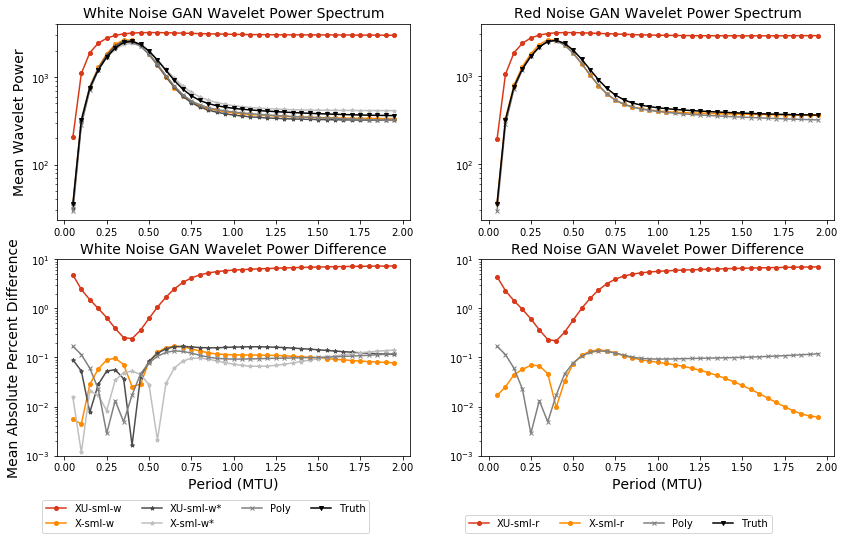

In [102]:
fig = plt.figure(figsize=(12, 8))
colors =[gan_index_color[gw] for gw in gw_index]
colors_red = [gan_index_red_colors[gw] for gw in gw_index]
colors_star = [gan_index_color[gw] for gw in gw_star_index]
gan_configs_white = ["XU-sml-w", "X-sml-w"]
gan_configs_star = ["XU-sml-w*", "X-sml-w*"]
gan_configs_red = ["XU-sml-r", "X-sml-r"]
#gan_configs_white = ["XU-lrg-w", "XU-med-w","XU-sml-w", "XU-tny-w", "X-med-w", "X-sml-w", "X-tny-w"] 
#gan_configs_star = ["XU-lrg-w*", "XU-med-w*", "XU-sml-w*", "XU-tny-w*", "X-sml-w*", "X-tny-w*"]
#gan_configs_red = ["XU-lrg-r", "XU-med-r", "XU-sml-r", "XU-tny-r", "X-med-r", "X-sml-r", "X-tny-r"]
truth_power = np.mean(wout_truth ** 2, axis=1)
mtu_widths = widths * 0.005
ms = 4
plt.subplots_adjust(0.05, 0.2, 0.95, 0.95, wspace=0.2)
plt.subplot(2, 2, 1)
white_plots = []
red_plots = []
for i in range(len(gw_index)):
    white_plots.extend(plt.plot(mtu_widths, np.mean(wavelets_white[i] ** 2, axis=1), 
                                marker='o', ms=ms, color=colors[i], label=gan_configs_white[i]))
for i in range(len(gw_star_index)):
    white_plots.extend(plt.plot(mtu_widths, np.mean(wavelets_white_star[i] **2, axis=1), 
                                marker="*", ms=ms, color=colors_star[i], label=gan_configs_star[i]))
white_plots.extend(plt.plot(mtu_widths, np.mean(wout_poly ** 2, axis=1), marker='x', ms=ms, color=(0.5, 0.5, 0.5), label="Poly"))
white_plots.extend(plt.plot(mtu_widths, np.mean(wout_truth ** 2, axis=1), marker='v', ms=ms, color='k', label="Truth"))

#plt.xticks(widths, 2 ** widths * np.sqrt(6) / np.pi, rotation=90)
#plt.legend(ncol=2)
plt.gca().set_yscale("log")
#plt.xlabel("Wavelength (timesteps)", fontsize=14)
plt.ylabel("Mean Wavelet Power", fontsize=14)
plt.title("White Noise GAN Wavelet Power Spectrum", fontsize=14)
plt.subplot(2, 2, 2)
for i in range(len(gw_index)):
    red_plots.extend(plt.plot(mtu_widths, np.mean(wavelets_red[i] ** 2, axis=1), 
                              marker='o', color=colors_red[i], ms=ms, label=gan_configs_red[i]))
red_plots.extend(plt.plot(mtu_widths, np.mean(wout_poly ** 2, axis=1), 
                          ms=ms, marker='x', color=(0.5, 0.5, 0.5), label="Poly"))
red_plots.extend(plt.plot(mtu_widths, np.mean(wout_truth ** 2, axis=1), ms=ms, marker='v', color='k', label="Truth"))
#plt.xticks(widths, widths, rotation=90)
plt.gca().set_yscale("log")

plt.title("Red Noise GAN Wavelet Power Spectrum", fontsize=14)
#plt.legend()
#plt.xlabel("Wavelength (timesteps)", fontsize=14)
plt.subplot(2, 2, 3)

for i in range(len(gw_index)):
    plt.plot(mtu_widths, np.abs((np.mean(wavelets_white[i] ** 2, axis=1) - truth_power)) / truth_power, 
             ms=ms, marker='o', color=colors[i], label=gan_configs_white[i])
for i in range(len(gw_star_index)):
    plt.plot(mtu_widths, np.abs((np.mean(wavelets_white_star[i] **2, axis=1) - truth_power)) / truth_power, 
             ms=ms, marker="*", color=colors_star[i], label=gan_configs_star[i])
plt.plot(mtu_widths, np.abs(np.mean(wout_poly ** 2, axis=1) - truth_power) / truth_power, ms=ms,
          marker='x', color=(0.5, 0.5, 0.5), label="Poly")
plt.ylim(1e-3, 1e1)
#plt.xticks(widths, 2 ** widths, rotation=90)
#plt.legend(ncol=3)
plt.gca().set_yscale("log")
plt.xlabel("Period (MTU)", fontsize=14)
plt.ylabel("Mean Absolute Percent Difference", fontsize=14)
plt.title("White Noise GAN Wavelet Power Difference", fontsize=14)

plt.subplot(2, 2, 4)
for i in range(len(gw_index)):
    plt.plot(mtu_widths, np.abs((np.mean(wavelets_red[i] ** 2, axis=1) - truth_power)) / truth_power, 
             ms=ms, marker='o', color=colors_red[i], label=gan_configs_red[i])
plt.plot(mtu_widths, np.abs(np.mean(wout_poly ** 2, axis=1) - truth_power) / truth_power, 
         ms=ms, marker='x', color=(0.5, 0.5, 0.5), label="Poly")
#plt.xticks(widths, 2 ** widths, rotation=90)
plt.gca().set_yscale("log")
plt.ylim(1e-3, 1e1)

plt.title("Red Noise GAN Wavelet Power Difference", fontsize=14)
#plt.legend(ncol=2)
plt.xlabel("Period (MTU)", fontsize=14)
fig.legend(white_plots, gan_configs_white + gan_configs_star + ["Poly", "Truth"], (0.05, 0.04), ncol=4)
fig.legend(red_plots, gan_configs_red + ["Poly", "Truth"], (0.55, 0.04), ncol=4)

plt.savefig("gan_climate_wavelet_all.pdf", bbox_inches="tight")
plt.savefig("gan_climate_wavelet_all.png", dpi=200, bbox_inches="tight")